# Reading the data

In [ ]:
# basic imports
import csv
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

dataPath = "../data/"

In [ ]:
# reading CSV file
reader = csv.reader(open(dataPath + 'features_2.csv', 'r'), delimiter=',')
data_full = np.array(list(reader))
reader = csv.reader(open(dataPath + 'all_endpoints_with_missing_values_012615.csv', 'r'), delimiter=',')
activity_full = np.array(list(reader))

In [ ]:
# feature names
feature_names = data_full[0, 1:]

# names of the proteins
protein_names = data_full[1:, 0]
protein_names1 = activity_full[1:, 0]
print 'Protein names equality check:', np.array_equal(protein_names1, protein_names)

# names of receptors
receptor_names = activity_full[0, 1:]

# Object-Feature matrix (proteins description)
X = data_full[1:, 1:].astype('double')

# Activity matrix
Y = activity_full[1:, 1:].astype('int16')

# Removing constant features
ind = np.var(X, axis = 0) != 0
X = X[:, ind]
feature_names = feature_names[ind]

# Number of features
N = X.shape[1]

In [ ]:
print receptor_names

# Training classifiers and printing results

In [ ]:
from sklearn.linear_model import LogisticRegression as LR
from sklearn.metrics import roc_curve, auc
from sklearn.cross_validation import StratifiedKFold as SKF
import sklearn

In [ ]:
def getB(n):
    if n == 0:
        return(None)
    if n == 1:
        return([[0], [1]])
    else:
        res0 = getB(n - 1)
        res = list()
        for a in res0:
            res.append([0] + a)
        for a in res0:
            res.append([1] + a)
        return(res)
def plotROCCurve(fpr, tpr, text, filename):
    """
     Plot a ROC curve from fpr, tpr
    """

    plt.rcParams['mathtext.fontset'] = 'stix'
    plt.rcParams['font.family'] = 'STIXGeneral'
    params = {'text.usetex' : True,
       'font.size' : 15,
#          'font.family' : 'lmodern',
       'text.latex.unicode': True}
    plt.rcParams.update(params) 
    plt.plot(fpr, tpr, label = None)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('FPR', fontsize=15)
    plt.ylabel('TPR', fontsize=15)
    plt.tick_params(axis='both', which='major')
    plt.title(str(text), fontsize=15)
    if filename != None:
        plt.savefig(filename + ".eps", bbox_inches = 'tight')
    plt.show()
def getShowROC(classifier, Xc, Yc):
        Ys = classifier.decision_function(Xc)
        fpr, tpr, _ = roc_curve(Yc, Ys)
        plotROCCurve(fpr, tpr, "ROC", None)

In [ ]:
class PCC:
    Xc = None
    Yc = None
    C = None
    X = None
    Y = None
    badValue = None
    m = 0
    def __init__(self):
        return None
    def initialize(self, m, X, Y, badValue):
        self.X = np.copy(X)
        self.Y = np.copy(Y)
        self.Xc = [None] * m
        self.Yc = [None] * m
        self.badValue = badValue
        self.m = m
        self.C = [None] * m
    #def fit(self, X, Y, badValue = 999):
    #    for i in range(Y.shape[1]):
    #        fitOne(self, X, Y, badValue, i)
    def fitOne(self, i):
        self.C[i] = None
        ind = np.where(self.Y[:, i] != self.badValue)
        X0 = self.X[ind]
        Yc = self.Y[ind][:, i]
        Y1 = np.copy(self.Y[ind][:, 0:i])
        
        #print Yc.shape
        #print Y1.shape
        
        for k in range(Y1.shape[0]):
            for j in range(Y1.shape[1]):
                if Y1[k, j] == self.badValue:
                    #print k, j
                    Y1[k, j] = self.predict(X0[k], j)
        
        if Y1.shape[1] > 0:
            #print X[ind].shape
            #print Y1.shape
            Xc = np.concatenate((self.X[ind], Y1), axis=1)
        else:
            Xc = self.X[ind]
        
        self.Xc[i] = Xc
        self.Yc[i] = Yc
        
        tmpLR = LR(fit_intercept = False)
        tmpLR.fit(Xc, Yc)
        self.C[i] = tmpLR
    def adjustOne(self, i, fprThresold = 0.2):
        Xc = self.Xc[i]
        Yc = self.Yc[i]
        #getShowROC(self.C[i], Xc, Yc)
        objInd = self.getIndexByFPR(i, fprThresold)
        self.setClassifierObject(i, objInd)
        self.showFPRTPR(i)
    def updatePredictions(self, j):
        for i in range(self.X.shape[0]):
            if self.Y[i][j] == self.badValue:
                self.Y[i][j] = self.predict(X[i], j)
    def showFPRTPR(self, i):
        Xc = self.Xc[i]
        Yc = self.Yc[i]
        classifier = self.C[i]
        N = len(np.where(Yc == 0)[0])
        P = len(np.where(Yc == 1)[0])
        TP = len(np.where((classifier.predict(Xc) == 1) & (Yc == 1))[0])
        FP = len(np.where((classifier.predict(Xc) == 1) & (Yc == 0))[0])
        print("Got FPR=%.1f %% TPR=%.1f %%" % (100. * FP / N, 100. * TP / P))
    def getIndexByFPR(self, i, fprLow):
        classifier = self.C[i]
        Xc = self.Xc[i]
        Yc = self.Yc[i]
        YScore = classifier.decision_function(Xc)
        Ys = np.argsort(YScore)[::-1]
        N = len(np.where(Yc==0)[0])
        P = len(np.where(Yc==1)[0])
        fpr0 = 0
        tpr0 = 0
        res = None
        for i in range(Ys.shape[0]):
            ansr = Yc[Ys[i]]
            if ansr == 0:
                fpr0 += 1
            if ansr == 1:
                tpr0 += 1
                
            if 1. * fpr0 / N >= fprLow and res == None:
                return(Ys[i])
    def setClassifierObject(self, i, index):
        classifier = self.C[i]
        Xc = self.Xc[i]
        classifier.intercept_ = 0
        classifier.intercept_ = -classifier.decision_function([Xc[index]])
    def probabilityItem(self, x, y):
        res = 1
        for i in range(len(y)):
            x1 = list(x) + y[0:i]
            if self.C[i] != None:
                res *= self.C[i].predict_proba([x1])[0][y[i]]
        return(res)
    def probabilityClasses(self, x):
        m0 = 0
        while m0 < self.m:
            if self.C[m0] == None:
                break
            m0 += 1
        Bm0 = getB(m0)
        res = np.zeros(self.m)
        for v in Bm0:
            for j in range(m0):
                if v[j] == 1:
                    res[j] += probabilityItem(self, x, v)
        return(res)
    def predict(self, x, i):
        return(self.probabilityClasses(x)[i] >= 0.5)

In [ ]:
a = PCC()
a.initialize(Y.shape[1], X, Y, 999)
for i in range(5):
    a.fitOne(i)
    a.adjustOne(i, 0.2)
    a.updatePredictions(i)

In [358]:
def getXY(classToTrain, X, Y, badValue = 999):
    """
    Get objects and answers for class classToTrain
    for which answers are available
    """
    
    haveAnswersObjectsIndices = np.where(Y[:, classToTrain] != badValue)
    classX = X[haveAnswersObjectsIndices, :][0]
    classY = Y[haveAnswersObjectsIndices, classToTrain][0]
    return classX, classY

Got FPR=20.0 % TPR=87.8 %
Got FPR=20.0 % TPR=93.8 %
Got FPR=20.0 % TPR=93.7 %
Got FPR=20.0 % TPR=89.3 %


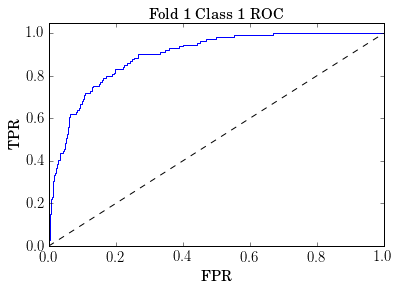

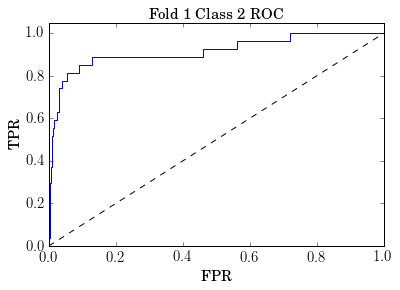

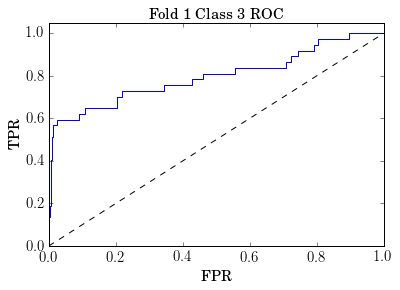

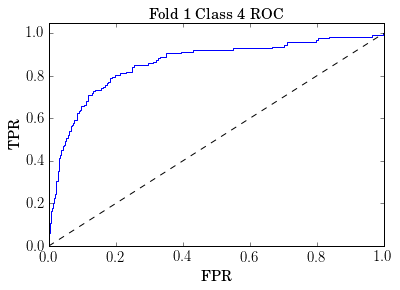

Got FPR=20.0 % TPR=87.5 %
Got FPR=20.0 % TPR=92.6 %
Got FPR=20.0 % TPR=89.8 %
Got FPR=20.0 % TPR=88.9 %


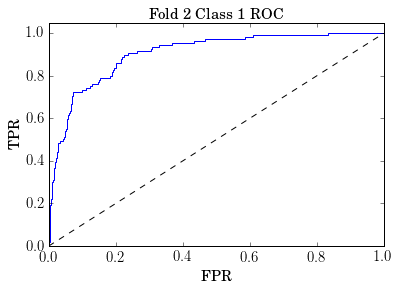

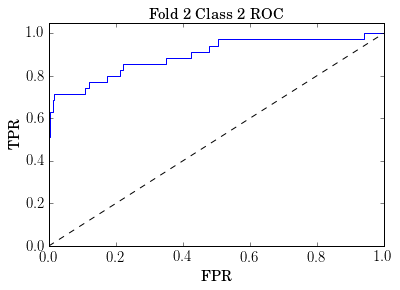

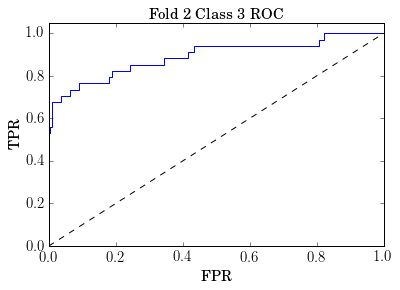

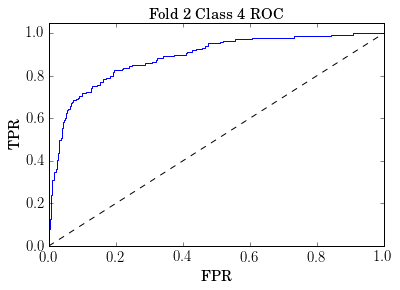

Got FPR=20.0 % TPR=89.5 %
Got FPR=20.0 % TPR=92.4 %
Got FPR=20.0 % TPR=89.9 %
Got FPR=20.0 % TPR=87.6 %


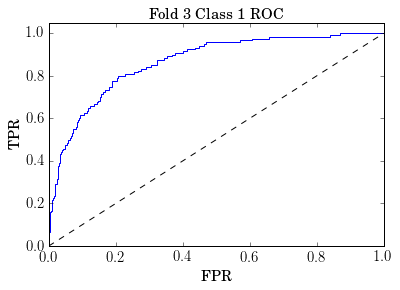

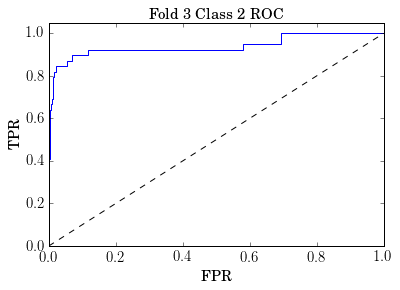

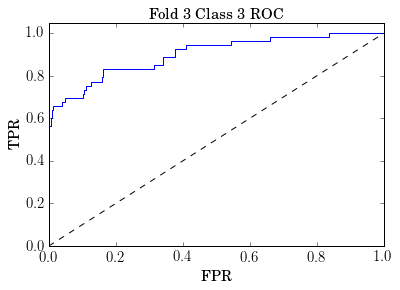

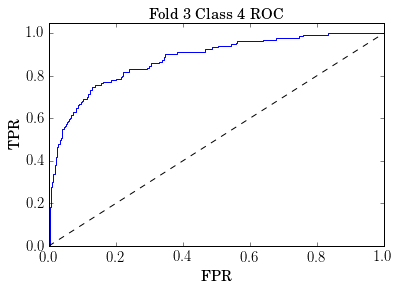

Got FPR=20.0 % TPR=87.0 %
Got FPR=20.0 % TPR=94.1 %
Got FPR=20.0 % TPR=88.7 %
Got FPR=20.0 % TPR=87.2 %


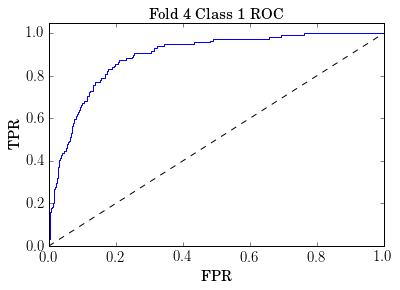

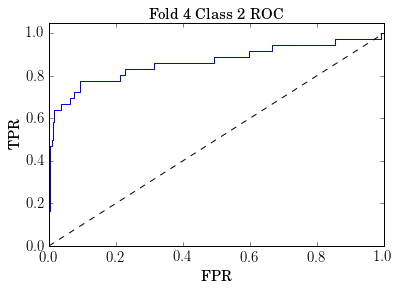

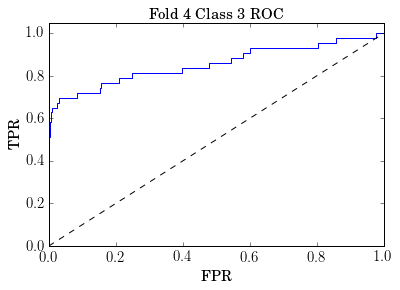

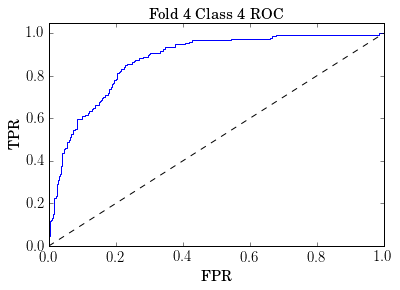

Got FPR=20.0 % TPR=88.1 %
Got FPR=20.0 % TPR=92.0 %
Got FPR=20.0 % TPR=91.0 %
Got FPR=20.0 % TPR=87.3 %


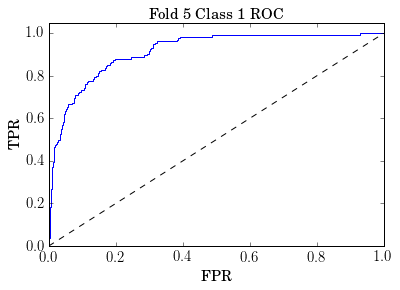

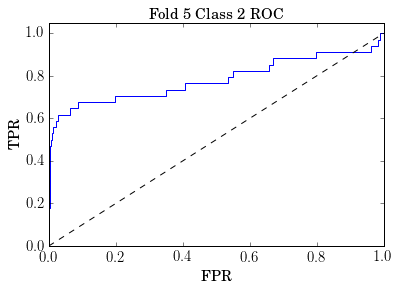

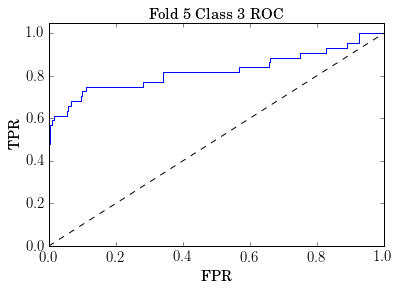

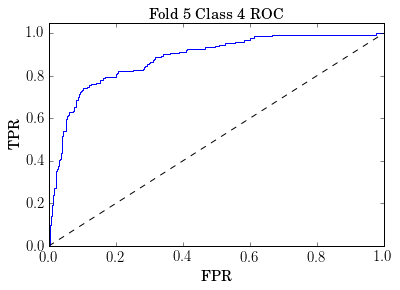

Class 1 AUC 0.9 +- 0.02
Class 2 AUC 0.88 +- 0.05
Class 3 AUC 0.85 +- 0.04
Class 4 AUC 0.88 +- 0.009


In [389]:
folds = 5
IFolds = sklearn.cross_validation.KFold(n = X.shape[0], n_folds=folds, shuffle=True,
                               random_state=32)
#IFolds = SKF(Y, folds)
maxC = 4

roc_auc = np.zeros((folds, maxC))
fold = 0
for ITrain, ITest in IFolds:
    # get train & test data
    XTrain, YTrain = X[ITrain], Y[ITrain]
    XTest,  YTest  = X[ITest],  Y[ITest]

    Ys = np.zeros(YTest.shape)
    
    algo = PCC()
    algo.initialize(YTrain.shape[1], XTrain, YTrain, 999)
    for i in range(maxC):
        algo.fitOne(i)
        algo.adjustOne(i, 0.2)
        algo.updatePredictions(i)
    
    for j in range(XTest.shape[0]):
        Ys[j] = algo.probabilityClasses(XTest[j])
    
    for i in range(maxC):
        ind = np.where(YTest[:, i] != 999)
        X1 = XTest[ind]
        Y1 = YTest[ind, i][0]
        Ys0 = Ys[ind, i][0]

        fpr, tpr, _ = roc_curve(Y1, Ys0)
        plotROCCurve(fpr, tpr, "Fold %d Class %d ROC" % (fold + 1, i + 1), None)
        roc_auc[fold][i] = auc(fpr, tpr)
    fold += 1
       
for i in range(maxC):
    auc_mean = np.mean(roc_auc[:, i])
    auc_std = np.std(roc_auc[:, i])
    print("Class %d AUC %.2g +- %.1g" % (i + 1, auc_mean, auc_std))